In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe, Vocab
from collections import Counter

import torch
import torch.nn as nn

import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# Load GloVe
glove = GloVe(name="6B", dim=100)

# Define special tokens
specials = ["<unk>", "<pad>"]

# Build a Counter from GloVe vocab (all frequency=1)
counter = Counter(glove.stoi.keys())

# Create Vocab properly
my_vocab = Vocab(counter, specials=specials)

vocab_size = len(my_vocab)
embedding_dim = glove.dim  # same as glove.vectors.size(1)

print("Vocab size:", vocab_size)
print("Embedding dim:", embedding_dim)

Vocab size: 400002
Embedding dim: 100


In [25]:
embedding_weights = glove.vectors
embedding_layer = nn.Embedding.from_pretrained(
    embedding_weights,
    freeze=True  # set to False if you want to fine‑tune the embeddings
)

This code defines a class called `TextClassifier` that represents a simple text classifier that uses an embedding layer, a hidden linear layer with a ReLU avtivation, and an output linear layer. The constructor takes the following arguments:

- `num_class`: The number of classes to classify.
- `freeze`: Whether to freeze the embedding layer.


In [26]:
from torch import nn

class TextClassifier(nn.Module):
    def __init__(self, num_classes,freeze=False):
        super(TextClassifier, self).__init__()
        self.embedding = embedding_layer
        # An example of adding additional layers: A linear layer and a ReLU activation
        self.fc1 = nn.Linear(in_features=100, out_features=128)
        self.relu = nn.ReLU()
        # The output layer that gives the final probabilities for the classes
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Pass the input through the embedding layer
        x = self.embedding(x)
        # Here you can use a simple mean pooling

        x = torch.mean(x, dim=1)
        # Pass the pooled embeddings through the additional layers
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)






First, let's create the model.


In [27]:
model=TextClassifier(num_classes=2,freeze=True)
model.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

##  Low-Rank Adaptation (LoRA)

PyTorch and the Hugging Face library provide robust tools for model manipulation with LoRA, but they are not intuitive. In this section, you delve into building a LoRA (Low-Rank Adaptation) implementation from scratch using PyTorch. LoRA is a general method, but it's commonly applied to the Attention layer. For the sake of simplicity, in this lab, you apply it to a Vanilla neural network. This decision is made because accessing the Attention Parameters in the PyTorch Encoder module can be challenging.


### LoRA
1) For any arbitrary layer of a network, you have the model with pretrained parameters $ W_0 $, which are the parameters of the model. If you only consider the attention parameters for each layer, at a minimum $ 4 \times m \times n$ for each layer. For many models, this can reach in the trillions of learnable parameters. Each time you fine-tune a new dataset, you have to store trillions of parameters.

2) $ \Delta W $ represents two matrices $ B $ and $ A $, where $ B $ and $ A $ are constrained such that $ B \in \mathbb{R}^{m \times r} $, $ A \in \mathbb{R}^{r \times n} $, and $ r \leq \min(m, n) $. The total number of parameters is $ A $ and $ B $ is much smaller than $ W_1$  and much easier to store.

$ W_1\approx W_0 + \Delta  W = W_0 + BA $



3) To train and predict, the forward pass holds $W_0$ constant.

$h = W_0 + \Delta W  = W_0x + BAx $





To scale $\Delta W \times \dfrac{\alpha'}{r}$, where $\alpha$ is a constant in $ r $.  Adjusting $\alpha'$ is similar to tuning the learning rate if the initialization is properly scaled. Therefore, you set $\alpha'$ to the first $ r $ you try and do not tune it further; just use $\alpha$. This scaling reduces the need to retune hyperparameters. The final form is:

$h =  W_0x +  \dfrac{\alpha'}{r} BAx=  W_0x +  \alpha BAx $

The following example illustrates the process.


$
W_0 + BA = 
\begin{bmatrix}
w_{11} & w_{12} & w_{13} & w_{14} \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
w_{21} & w_{22} & w_{23} & w_{24} \\\\\\\\
w_{31} & w_{32} & w_{33} & w_{34} \\\\\\\\
w_{41} & w_{42} & w_{43} & w_{44} \\\\\\\\
\end{bmatrix} +
\begin{bmatrix}
a_1 \\\\\\\\
a_2 \\\\\\\\
a_3 \\\\\\\\
a_4 \\\\\\\\
\end{bmatrix}
\begin{bmatrix}
b_1 & b_2 & b_3 & b_4 \\\\\\
\end{bmatrix}
$

This illustrates the product of matrices $ A $ and $ B $, denoted as $ AB $, which can be added to $ W_0 $. However, the resulting matrix $ W_0 + AB $ is limited depending on the dimensions of $ A $ and $ B $. This limitation is due to the concept of rank.



### Rank
The rank of a matrix is the number of dimensions the rows of the matrix "live in."  A square matrix is said to be **full rank** if its <a href='https://en.wikipedia.org/wiki/Rank_(linear_algebra)?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01'>rank</a> is equal to the number of its rows or columns. Let's make this idea more intuitive with an example.


In [28]:
from sympy import Matrix, init_printing
from numpy.linalg import matrix_rank
from scipy.linalg import null_space
from sympy import Matrix, init_printing
init_printing()

In [29]:
def plot_matrix_and_subspace(F):
    assert F.shape[0] == 3, "Matrix F must have rows equal to 3 for 3D visualization."
    
    ax = plt.figure().add_subplot(projection='3d')
    
    # Plot each column vector of F as a point and line from the origin
    for i in range(F.shape[1]):
        ax.quiver(0, 0, 0, F[0, i], F[1, i], F[2, i], color='blue', arrow_length_ratio=0.1, label=f'Column {i+1}')

    if F.shape[1] == 2:
        # Calculate the normal to the plane spanned by the columns of F if they are exactly two
        normal_vector = np.cross(F[:, 0], F[:, 1])
        # Plot the plane
        xx, yy = np.meshgrid(np.linspace(-3, 3, 10), np.linspace(-3, 3, 10))
        zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2] if normal_vector[2] != 0 else 0
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Spanned Plane')

    # Set plot limits and labels
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    ax.set_xlabel('$x_{1}$')
    ax.set_ylabel('$x_{2}$')
    ax.set_zlabel('$x_{3}$')
    #ax.legend()

    plt.show()

In [30]:
def plot_matrix_and_subspace(F):
    assert F.shape[0] == 3, "Matrix F must have 3 rows to represent 3D space."

    ax = plt.figure().add_subplot(projection='3d')
    
    # Plot each column vector of F
    for i in range(F.shape[1]):
        ax.quiver(0, 0, 0, F[0, i], F[1, i], F[2, i], color='blue', arrow_length_ratio=0.1, label=f'Column {i+1}')

    # Calculate the null space of the transpose of F
    normal_vector = null_space(F.T)
    
    # Check that the null space is 1-dimensional
    if normal_vector.shape[1] == 1:
        normal_vector = normal_vector[:, 0]  # Simplify the array to 1D
        # Create a meshgrid for the plane
        xx, yy = np.meshgrid(np.linspace(-3, 3, 10), np.linspace(-3, 3, 10))
        # Calculate corresponding z coordinates based on the plane equation ax + by + cz = 0
        zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2] if normal_vector[2] != 0 else 0
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Spanned Plane')
    else:
        print("The null space is not 1-dimensional, so a unique plane cannot be determined.")

    # Set plot limits and labels
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    #ax.legend()

    plt.show()



In the context of Low-Rank Adaptation (LoRA), where $B \in \mathbb{R}^{d \times r}$, the matrix $B$:





In [31]:
B=torch.tensor([[1,0],[0,1],[0,0]]).numpy()

Matrix(B)


⎡1  0⎤
⎢    ⎥
⎢0  1⎥
⎢    ⎥
⎣0  0⎦

This $3 \times 2$ matrix has columns that span a 2-dimensional subspace in $\mathbb{R}^3$. Specifically, the columns of $B$ are:

- $\mathbf{b}_1 = \begin{bmatrix} 1 \\\\\\\\\\\\\\\\\\\\\\\\\\\\ 0 \\ 0 \end{bmatrix}$
- $\mathbf{b}_2 = \begin{bmatrix} 0 \\\\\\ 1 \\ 0 \end{bmatrix}$

These columns are standard basis vectors for the $xy$-plane in $\mathbb{R}^3$, and, thus, they span the $xy$-plane shown in green in the following image. Muliplying each column vector in blue by a scaler always falls in the plane.


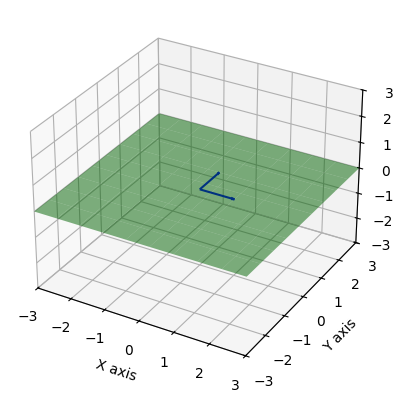

In [32]:
plot_matrix_and_subspace(B)

In this scenario, the vectors, despite each having three components, can reach any point on the two-dimensional green plane depicted in the image. These vectors span the green plane, which resides within a two-dimensional subspace. This subspace's dimension, also known as its 'rank', is two—corresponding to the dimensionality of the plane. If the rank were three, any point in the 3D space could be reached by some combination of the columns of $𝐵$. The rank of a matrix can be determined by using the matrix_rank function provided by NumPy.


In [33]:
matrix_rank(B)

np.int64(2)

Here, you plot a different matrix where the matrix spans a different plane, but the rank remains two.


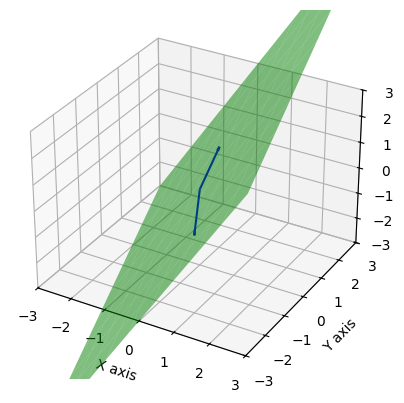

rank of B 2


In [34]:
B_=torch.tensor([[1,0],[-2,1],[0,1]]).numpy()
plot_matrix_and_subspace(B_)
print("rank of B",matrix_rank(B_))

In [35]:
matrix_rank(B)

np.int64(2)

Here, you present the matrix ```A```. The rank of this matrix is also two.


In [36]:
A=torch.tensor([[1,1,-1,1,0],[-2,2,2,0,1]]).numpy()
Matrix(A)


⎡1   1  -1  1  0⎤
⎢               ⎥
⎣-2  2  2   0  1⎦

In [37]:
matrix_rank(A)

np.int64(2)

For the matrices $ C = BA $, if $B $ and $ A $ both have a rank of $ r $:


In [38]:
C=B@A
Matrix(C)


⎡1   1  -1  1  0⎤
⎢               ⎥
⎢-2  2  2   0  1⎥
⎢               ⎥
⎣0   0  0   0  0⎦

 The columns of $ C $ will have the same rank as $ B $. Furthermore, the span of the columns of $ C $ will be the same as the span of the columns of $ B $.


rank of C 2


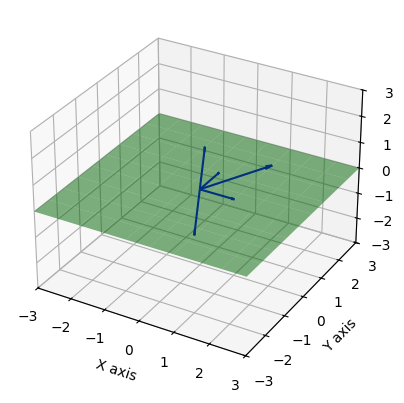

In [39]:
print("rank of C",matrix_rank(C))
plot_matrix_and_subspace(C)

### Understanding LoRA in PyTorch

LoRA (Low-Rank Adaptation) is relatively simple to initialize in PyTorch. You initialize LoRA with the dimensions of the input (`in_dim`), $ m $, output (`out_dim`), $n $, a rank (`rank`), $ r $, and a scaling factor `alpha`. The parameters are initialized as follows:

```
self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
```

The use of  ```nn.Parameter``` makes these values learnable parameters.

In the forward function, LoRA uses the notation $BAx$ PyTorch, the input vector is a row, so the output becomes $x^TA^TB^T$ will drop the trapose from now on. The forward pass is implemented as:
```
x = self.alpha * (x @ self.A @ self.B)
```
The use of  ```nn.Parameter``` makes these values learnable parameters.



In [40]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

This class ```LinearWithLoRA```  copies the original linear model and creates a ```LoRALayer``` object. 
```
self.linear = linear.to(device)
 self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        ).to(device)
```

Then, in the forward method apply both the original linear model and the output Lora model to the input x and add them together ```self.linear(x) + self.lora(x)```. This corresponds to:

 $xW_0 + xAB $


In [41]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear.to(device)
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        ).to(device)

    def forward(self, x):
        
        return self.linear(x) + self.lora(x)

### Applying LoRA
To fine-tune with LoRA, first, load a pretrained TextClassifier model with LoRA (while freezing its layers), load its pretrained state from a file, and then disable gradient updates for all of its parameters to prevent further training. Here, you will load a model that was pretrained on the AG NEWS dataset, which is a dataset that has 4 classes. Note that when you initialize this model, you set `num_classes` to 4. Moreover, the pretrained AG_News model was trained with the embedding layer unfrozen. Hence you will initialize the model with `freeze=False`. Although you are initializing the model with layers unfrozen and the wrong number of classes for your task, you will make modifications to the model later on that correct this:


In [45]:
from urllib.request import urlopen
import io

model_lora=TextClassifier(num_classes=4,freeze=False)
model_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_lora.load_state_dict(state_dict)

# Here, you freeze all layers:
for parm in model_lora.parameters():
    parm.requires_grad=False
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

Note that the `for` loop in the above code froze all of the layers in the neural network, including the embedding layer.


Let's view all of the modules in the object.


In [46]:
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

Your task now is to replace the hidden layer with a LoRA layer. You can access the hidden layer as follows:


In [47]:
model_lora.fc1

Linear(in_features=100, out_features=128, bias=True)

The following replaces this layer with a LoRA layer:


In [48]:
model_lora.fc1=LinearWithLoRA(model_lora.fc1,rank=2, alpha=0.1).to(device)

Let's look at the hidden layer again to ensure that it is indeed converted to a LoRA layer.


In [49]:
model_lora.fc1

LinearWithLoRA(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (lora): LoRALayer()
)

At this point, training the model is similar, with the only difference being that, except for the output layer, only the learnable parameters 
```A``` and  ```B``` will be updated. The code to select the values for  `r` and `alpha`, which is not run, is nonetheless provided herein for your convenience.


In [ ]:
model_lora.to(device)

<details>
<summary><b>Click here to see code to select r and alpha</b></summary>
    
```python 
ranks = [1, 2, 5, 10]
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]

results=[]
accuracy_old=0
# Loop over each combination of 'r' and 'alpha'
for r in ranks:
    for alpha in alphas:
        print(f"Testing with rank = {r} and alpha = {alpha}")
        model_name=f"model_lora_rank{r}_alpha{alpha}_AGtoIBDM_final_adam_"
        
        model_lora=TextClassifier(num_classes=4,freeze=False)
        model_lora.to(device)
        
        urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')
        
        stream = io.BytesIO(urlopened.read())
        state_dict = torch.load(stream, map_location=device)
        model_lora.load_state_dict(state_dict)
        
        for parm in model_lora.parameters():
            parm.requires_grad=False
        
        model_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True)
        model_lora.fc1=LinearWithLoRA(model_lora.fc1,rank=r, alpha=alpha )
        optimizer = torch.optim.Adam(model_lora.parameters(), lr=LR)

        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
        
        model_lora.to(device)
        
        
        

        
        train_model(model_lora, optimizer, criterion, train_dataloader, valid_dataloader, epochs=300, model_name=model_name)
        
        accuracy=evaluate(valid_dataloader ,  model_lora, device)
        result = {
            'rank': r,
            'alpha': alpha,
            'accuracy':accuracy
        }

        # Append the dictionary to the results list
        results.append(result)
        
        
        
        

        if accuracy>accuracy_old:
            print(f"Testing with rank = {r} and alpha = {alpha}")
            print(f"accuracy: {accuracy} accuracy_old: {accuracy_old}" )
            accuracy_old=accuracy
            torch.save(model.state_dict(), f"{model_name}.pth")
            save_list_to_file(cum_loss_list, f"{model_name}_loss.pkl")
            save_list_to_file(acc_epoch, f"{model_name}_acc.pkl")
            
        
```       


From ```model_lora.fc1.lora```, you can obtain the learnable parameters A and B.  


In [52]:
B=model_lora.fc1.lora.B
print("B",B)
print("\n Number of elements in the tensor B",B.numel())

B Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [53]:
A=model_lora.fc1.lora.A
print("A",A)
print("\n Number of elements in the tensor A",A.numel())

A Parameter containing:
tensor([[-0.3689,  0.0994],
        [-0.8978,  0.1476],
        [-0.4584,  0.9774],
        [ 0.1917,  0.5272],
        [-0.5472,  0.0901],
        [-0.7068,  0.7279],
        [ 0.1162,  0.4160],
        [-0.0873, -0.6468],
        [ 1.1748, -0.9627],
        [ 0.5339,  0.2325],
        [-0.5349,  0.1255],
        [-0.3747, -0.4473],
        [-0.1762, -0.2830],
        [ 0.7281, -0.3500],
        [-0.2521, -0.4199],
        [ 0.2257,  0.4198],
        [ 0.0652,  0.7232],
        [-0.7841,  2.0975],
        [ 0.0622,  0.8476],
        [ 0.4889,  1.2551],
        [-0.5386,  0.1066],
        [ 0.6160,  0.0684],
        [-0.6848,  0.1568],
        [ 1.5566, -0.0676],
        [-0.8902, -0.3868],
        [ 0.4463,  0.0420],
        [-0.1612,  0.9080],
        [-1.5078,  0.8389],
        [-0.7435,  0.4015],
        [-0.4063, -0.4742],
        [ 0.0156,  0.5159],
        [-0.0050,  1.2986],
        [-0.2676, -1.1209],
        [-0.6892,  0.3308],
        [ 0.1015,  0.434

A and B have approximately 450 parameters. If you were to store the entire linear layer, you would have 12,800 parameters, which is around 28 times more. Remember, this is possibly the simplest model that you can have.


In [54]:

print("\n Number of elements in the tensor A",model_lora.fc1.linear.weight.numel())



 Number of elements in the tensor A 12800


The model object is created and the pretrained parameters are loaded:


In [ ]:

model_load_lora = TextClassifier(num_classes=4,freeze=False)
model_load_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_load_lora.load_state_dict(state_dict)

model_load_lora

The LoRA layer object is added to the original hidden layer.


In [ ]:
model_load_lora.fc1=LinearWithLoRA(model_load_lora.fc1,rank=2, alpha=0.1)
model_load_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)